In [1]:
import numpy as np
from scipy.stats import rv_discrete
from numpy import genfromtxt
import matplotlib.pyplot as plt
from numpy import genfromtxt

In [2]:
#load the saved data for further use:
t_list = genfromtxt('pyrazine t_list.csv', delimiter=',', dtype=np.complex128)
auto_list = genfromtxt('pyrazine auto_list.csv', delimiter=',', dtype=np.complex128)

In [3]:
#time axis
timearray = np.array(t_list)*0.6582119  # hbar = 0.6582119 (eV fs)
dtime  = t_list[2]-t_list[1]

restime = len(timearray)
denergy  = 2 * np.pi / (restime * dtime)
energyaxis = np.concatenate((np.arange(0, restime/ 2-1),
                        np.arange(-restime/ 2, 0))) * denergy
ZeroPointEnergy = np.load('pyrazine zero point energy.npy')
energyaxisshifted = energyaxis - ZeroPointEnergy
energyaxisshifted_mask = (energyaxisshifted >= -1.1) & (energyaxisshifted <= 1.4)

autoarray = np.array(auto_list)
#autoarray  *= np.cos(np.pi*timearray/(2*np.max(timearray))) # neglecting this damping function won't result in big difference
autoarray *= np.exp(-timearray/30) #broadening function
autofft  = np.fft.ifft(autoarray)
autofft *= 40 #adjustable scaling factor

In [4]:
autolist = np.array(auto_list)
true_f_t_real=np.real(autolist)
true_f_t_imag=np.imag(autolist)

true_spectrum = np.abs(np.real(autofft))-np.min(np.abs(np.real(autofft)))
true_spectrum_prob = true_spectrum[energyaxisshifted_mask]
true_spectrum_prob /= np.sum(true_spectrum_prob)

In [5]:
def total_variation_distance(p, q):
    return 0.5 * np.sum(np.abs(p - q))

In [6]:
np.random.seed(0)

tvd_thresholds = [0.04, 0.03, 0.02, 0.01]
consecutive_required = 5
max_measurements = 300000
step = 1000

stable_counts = {tvd: 0 for tvd in tvd_thresholds}
required_measurements = {tvd: None for tvd in tvd_thresholds}
initial_measurements = {tvd: None for tvd in tvd_thresholds}
required_tvds_fft = {tvd: None for tvd in tvd_thresholds}
empirical_spectrum_probs = {tvd: None for tvd in tvd_thresholds}

sample_counts = []
tvds_fft = []

for N in range(step, max_measurements + 1, step):
    estimated_f_t_complex = []

    for fr, fi in zip(true_f_t_real, true_f_t_imag):
        
        p0_r = (1 + fr) / 2
        samples_r = np.random.choice([1, 0], size=N, p=[p0_r, 1 - p0_r])
        r = -(2 * np.mean(samples_r) - 1)

        p0_i = (1 + (-fi)) / 2
        samples_i = np.random.choice([1, 0], size=N, p=[p0_i, 1 - p0_i])
        i_val = 2 * np.mean(samples_i) - 1

        estimated_f_t_complex.append(r + 1j * i_val)

    estimated_f_t_complex = np.array(estimated_f_t_complex)
    
    estimated_spectrum = np.fft.ifft(estimated_f_t_complex * np.exp(-timearray/30)) * 40
    estimated_spectrum_prob_inte = np.abs(np.real(estimated_spectrum)) - np.min(np.abs(np.real(estimated_spectrum)))
    estimated_spectrum_prob = estimated_spectrum_prob_inte[energyaxisshifted_mask]
    estimated_spectrum_prob /= np.sum(estimated_spectrum_prob)

    current_tvd_fft = total_variation_distance(true_spectrum_prob, estimated_spectrum_prob)
    sample_counts.append(N)
    tvds_fft.append(current_tvd_fft)

    for tvd in tvd_thresholds:
        if current_tvd_fft < tvd:
            stable_counts[tvd] += 1
            if stable_counts[tvd] == 1:
                initial_measurements[tvd] = N
                empirical_spectrum_probs[tvd] = estimated_spectrum_prob.copy()
            if stable_counts[tvd] == consecutive_required and required_measurements[tvd] is None:
                required_measurements[tvd] = initial_measurements[tvd]
                required_tvds_fft[tvd] = current_tvd_fft
                print(f"Number of Measurements Reaching TVD Threshold of {tvd*100:.2f}%：{initial_measurements[tvd]}, Actual TVD：{current_tvd_fft*100:.2f}%")
        else:
            stable_counts[tvd] = 0

Number of Measurements Reaching TVD Threshold of 4.00%：16000, Actual TVD：3.84%
Number of Measurements Reaching TVD Threshold of 3.00%：21000, Actual TVD：2.95%
Number of Measurements Reaching TVD Threshold of 2.00%：54000, Actual TVD：1.66%
Number of Measurements Reaching TVD Threshold of 1.00%：214000, Actual TVD：0.95%


Text(0, 0.5, 'Total Variation Distance (TVD)')

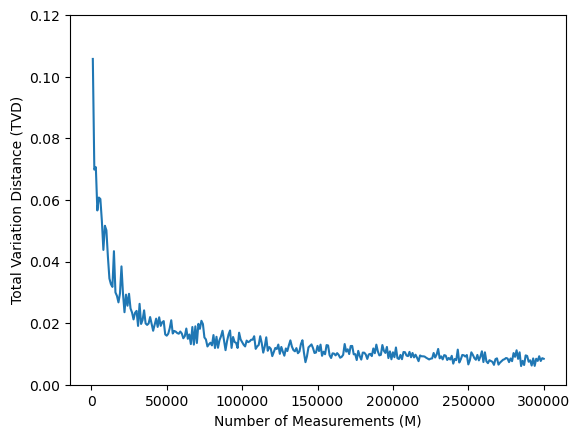

In [7]:
plt.plot(sample_counts, tvds_fft)
plt.ylim(0, 0.12)
plt.xlabel("Number of Measurements (M)")
plt.ylabel("Total Variation Distance (TVD)")

Text(0, 0.5, 'Intensity')

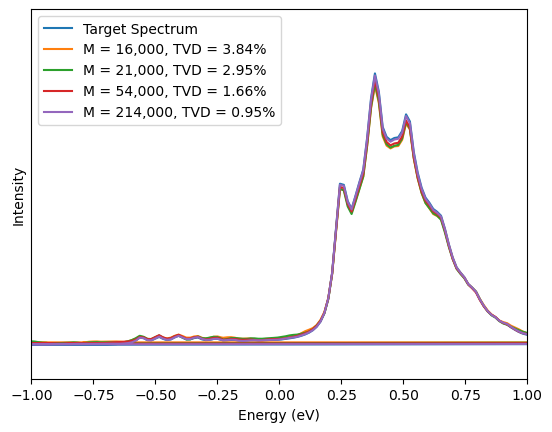

In [8]:
plt.plot(np.real(energyaxisshifted[energyaxisshifted_mask]), true_spectrum_prob, label='Target Spectrum')

sorted_tvds = sorted([tvd for tvd in required_measurements if required_measurements[tvd] is not None],
                     key=lambda x: required_measurements[x])

for i, tvd in enumerate(sorted_tvds):
    prob = empirical_spectrum_probs[tvd]
    label = f'M = {required_measurements[tvd]:,}, TVD = {required_tvds_fft[tvd]*100:.2f}%'
    plt.plot(np.real(energyaxisshifted[energyaxisshifted_mask]), prob, label=label)

plt.legend(loc='best')
plt.ylim(-0.005, 0.05)
plt.yticks([])
plt.xlim(-1, 1)
plt.xlabel("Energy (eV)")
plt.ylabel("Intensity")